## DSGE w. Feedback - Numerical Simulations

### Imports

In [1]:
%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import pickle

In [3]:
import steadystate
import model
import graphs

-----
# Rebuilding Investment Based on Sharpe Ratio

In [4]:
def step(t: float, x: np.ndarray, p: dict, err:float):
    """Iteration of one step in the simulation
    
    Parameters
    ----------
    t : float
        Current timestep t
    x : np.ndarray
        state variables z, c, n, b, w, k, q, g, s, news, inc, xiz, xin
    p : dict
        Parameters from simulation
        
    Returns
    -------
    bound : float
        Upper bound on consumption
    """
    # Variables for the simulation
    z_, xiz_, c_, n_, b_, w_, k_, m_, k__, q_, g_, s_, s0_, mu_, sig2_, news_, c0_, sharpe_ = x
        
    # Random technology process
    if p['steady_state']: 
        rand = np.random.normal(0,p['sigmaZ'])
    else: 
        rand = np.random.normal(0,p['sigmaZ'])
    xiz = p['etaZ'] * xiz_ + np.sqrt(1 - p['etaZ'] ** 2) * rand
    z = p['zbar'] * np.exp(xiz)

    # Determine Consumption
    c = model.bisection(z, g_, k_, p)

    # Working hours via market clearing
    n = ((c / z) ** (-1 * p['mu']) - p['alpha'] * k_ ** (-1 * p['mu']))
    n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])
    
    # Firm observes desired working hours, sets the wage accordingly
    rho = -1 * p['mu']
    temp = (p['alpha'] * k_ ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    w = (1 - p['alpha']) * z * temp * (n ** (rho - 1))
        
    # Income
    income = w * n + (b_  + q_ * k__) / (1 + p['inflation'])
    m = g_ * income - c 
    
    # Investment & Bonds
    investment = income * (1 - g_)
    b = (1 + p['interest']) * s_ * investment
    
    # Capital & Risky return
   
    k = (1 - p['depreciation']) * k_ + investment * (1 - s_)
    temp = (p['alpha'] * k ** rho + (1 - p['alpha']) * n ** rho) 
    temp = temp ** ((1 / rho) - 1)
    q = p['alpha'] * z * temp * k ** (rho - 1)
    
    # Returns to the household's portfolio
    #w_b = b_ / (b_ + k__)
    #port_ret = w_b * p['interest'] + (1 - w_b) * q_
    
    w_b = k_ / (b_+k_)
    port_ret = q_#k_ / (b_+k_) * q_
     
    # Expectations are based on EWMA (returns and volatility)
    
    mu =  p['memory_1'] * mu_ + (1 - p['memory_1']) * port_ret
    sig2 =  p['memory_1'] * sig2_ + (1 - p['memory_1']) * (port_ret - mu_)**2
    
    sharpe = (p['interest'] -  mu) / np.sqrt(sig2)
    
    
    
    c0 =  p['memory_2'] * c0_ + (1 - p['memory_2']) * ((c_/c)-1)
    
    
    
    s0 = sharpe
    news = p['ratio']*s0 + (1-p['ratio'])*(c0) #+ np.random.uniform(-p['ex_news'],p['ex_news'])
    
    # Risk-weighted excess returns are the signal
    if p['steady_state']: 
        s0 = 1e9 
         # s0 large = good signal
    
    # Decision on Spending and Investment Allocation
    g = g_
    
    financial_risk = np.random.beta(a=p['q_shock'], b=1)
    q = q * financial_risk
    
    s = 0.5 * ((p['s_max'] - p['s_min']) * np.tanh(p['s_theta'] * news) + p['s_max'] + p['s_min'])
    
    return z, xiz, c, n, b, w, k, m, k_, q, g, s, s0, mu, sig2, news, c0, sharpe

# TO CHANGE THE STEP DO NOT CHANGE THE RETURN VARIABLES

Observable stylized facts to check: <br>
- Magnitude of annualised Sharpe ratio
- Duration of crises 

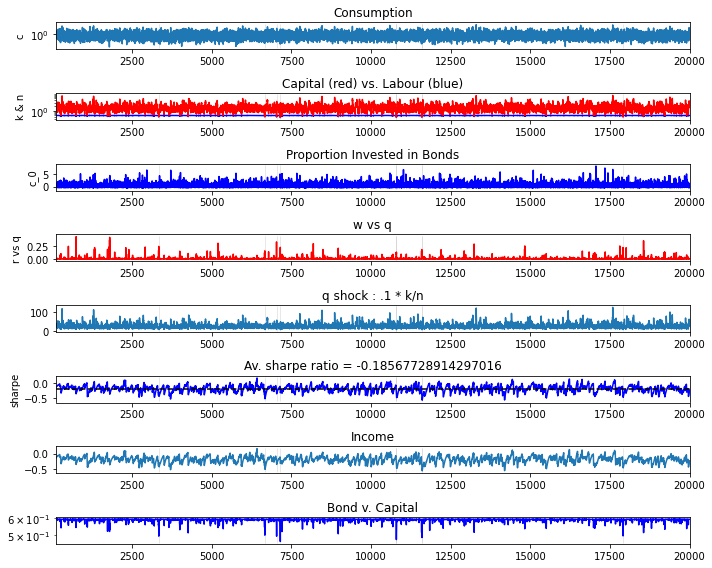

In [5]:
params = {
    # Noise Parameters
    'etaZ':0.5, 'zbar':1.0,
    # Empirical Parameters
    'inflation':0.0015, 'interest':0.001, 'depreciation':0.1,
    # Quasi-fixed parameters
    's_min':0, 's_max':1, 'memory_1':0.98,'memory_2':.5, 'gamma':1.0, 'alpha':0.33, 'mu':7.32,
    # Variable parameters
    'sigmaZ':.8, 'q_shock':10, 's_theta': 10, 'ratio':.5, 'steady_state' : False}

params_steady = copy.copy(params)
params_steady['depreciation'] = 0 
params_steady['steady_state'] = True 

start = dict(z=1, xiz=1, c=1, n=1, b=1, w=1, k=.1, m=0.0, k_=0.0, 
             q=0.02, g=0.7, s=0.5, s0=0.0, mu=0.01, sig2=1e-5, news=0, c0=0, income=0)

T = 20000
np.random.seed(40)
view = [100, T]

df_steady = model.simulate(start, params_steady, step_func=step, t_end=T, err = 1e-20)
df = model.simulate(start, params, step_func=step, t_end=T, err = 1e-20)

df.loc[:,'crisis'] = 0.5 * (1.0 + np.sign(df.n - df.k))
df.loc[:,'inv'] = 100 * (1-df.loc[:,'g'])
df.loc[:,'bc'] = df.b / df.c
df.loc[:,'utility'] = np.log(df.c) - params['gamma'] * (df.n ** 2)

df = df.iloc[view[0]:view[1],:]

plots = {
        'ln Consumption & Capital' : [df.loc[:,['c','k']], True],
        'Sentiment' : [df.s, False],
        'ln Labour' : [df.loc[:,['n','k']], True],
        'ln Wages' : [df.w, True],
        'M' : [df.m, False],
        'Crisis' : [df.crisis, False],
        'ln Capital' : [df.loc[:,['k']], True],
        'ln Returns' : [df.q, True],
    }


fig, ax = plt.subplots(nrows=8, ncols=1)
ax[0].plot(df.c, label='c')
#ax[0].plot(df_steady.c, color='yellow' , linestyle = '--')
ax[0].set_ylabel('c')
#ax[0].plot(df.c0, color='red')
ax[0].set_title('Consumption')
ax[0].set_yscale('log')

ax[1].plot(df.n, label='n', color='blue')
#ax[1].plot(df_steady.n, color = 'green')
ax[1].plot(df.k, label='k', color='red')
#ax[1].plot(df_steady.k, label='k', color='green')
ax[1].set_ylabel(r'k & n')
ax[1].set_title('Capital (red) vs. Labour (blue)')
ax[1].set_yscale('log')

ax[2].plot(df.c0, label='s', color='blue')
ax[2].set_ylabel(r'c_0')
#ax[2].plot(np.exp(df.c0), color='red')
ax[2].set_title('Proportion Invested in Bonds')

a = ax[5]
sharpe = df.s0
a.plot(sharpe, color='blue')

a.axhline(sharpe.mean(), linestyle = '--', color='black')
a.set_ylabel('sharpe')
a.set_title(r'Av. sharpe ratio = ' + str(sharpe.mean()))


ax[3].set_ylabel('r vs q')
ax[3].axhline(params['interest'],color='gray')
ax[3].plot(df.q, label='c0', color='red')
#ax[3].axhline(params['interest'], color='red', linestyle='--')
ax[3].set_title('w vs q')


ax[4].set_title(r'q shock : .1 * k/n')
ax[4].plot((df.k/df.n)*params['q_shock'])

ax[6].set_title(r'Income')
ax[6].plot(df.income)

ax[7].set_title(r'Bond v. Capital')
ax[7].plot(df.n, color='blue')
ax[7].set_yscale('log')

for a in ax:
    low,high = a.get_ylim()
    a.fill_between(df.index, low, high, where=df.n>df.k, alpha=0.5, color='lightgray')
    a.set_xlim(view[0], view[1])

fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

<ipython-input-6-b72b66c71d84>:6: RuntimeWarning: divide by zero encountered in log
  ax.plot(histo[1][:-1], np.log(histo[0]), 'o', label = r'Out of Eq.')
<ipython-input-6-b72b66c71d84>:7: RuntimeWarning: divide by zero encountered in log
  ax.plot(histo_steady[1][:-1], np.log(histo_steady[0]), 'o', label = r'Equilibrium')


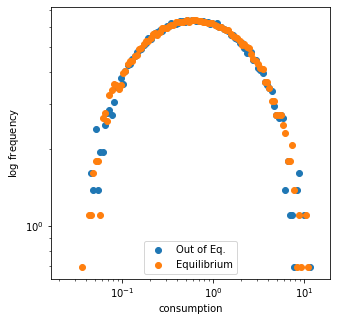

In [6]:
bins = np.logspace(-3,2,200)
histo = np.histogram(df.c , bins = bins)
histo_steady = np.histogram(df_steady.c , bins = bins)

fig, ax = plt.subplots(figsize= (5,5))
ax.plot(histo[1][:-1], np.log(histo[0]), 'o', label = r'Out of Eq.')
ax.plot(histo_steady[1][:-1], np.log(histo_steady[0]), 'o', label = r'Equilibrium')
ax.set_yscale('log')
ax.set_xlabel('consumption')
ax.set_ylabel(r'$\log$ frequency')
ax.set_xscale('log')
plt.legend()

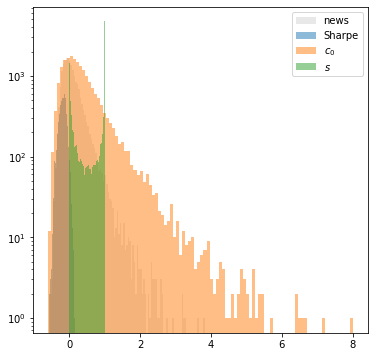

In [7]:
fig, ax = plt.subplots(figsize = (6,6))
ax.hist(df.news, bins=100, label='news', color='lightgray', alpha=0.5)
ax.hist(df.s0, bins=100, label='Sharpe', alpha=0.5)
ax.hist(df.c0, bins=100, label=r'$c_0$', alpha=0.5)
ax.hist(df.s, bins=100, label=r'$s$', alpha=0.5)
ax.set_yscale('log')
ax.legend()
plt.show()

In [10]:
qshock_iter = np.logspace(-1,1.3,20)
ratio_iter = np.linspace(0,1,20)

start = dict(z=1, xiz=1, c=1, n=1, b=1, w=1, k=.1, m=0.0, k_=0.0, 
             q=0.02, g=0.7, s=0.5, s0=0.0, mu=0.01, sig2=1e-5, news=0, c0=0, income=0)

T = 1000 #***set T >> 20k ***
n = len(ratio_iter)*len(qshock_iter)
np.random.seed(40)

cr_iter = np.zeros((len(ratio_iter), len(qshock_iter)))
sharpe_iter = np.zeros((len(ratio_iter), len(qshock_iter)))

count = 0

for i1, ratio in enumerate(ratio_iter):
    for i2, qshock in enumerate(qshock_iter):
        
        params = {
        # Noise Parameters
        'etaZ':0.5, 'zbar':1.0,
        # Empirical Parameters
        'inflation':0.0015, 'interest':0.001, 'depreciation':0.1,
        # Quasi-fixed parameters
        's_min':0, 's_max':1, 'memory_1':0.98,'memory_2':.5, 'gamma':1.0, 'alpha':0.33, 'mu':7.32,
        # Variable parameters
        'sigmaZ':.8, 'q_shock':qshock, 's_theta': 10, 'ratio':ratio, 'steady_state' : False}

        df = model.simulate(start, params, step_func=step, t_end=T, err = 1e-20)

        crises = 0.5 * (1.0 + np.sign(df.n - df.k))
        cr_iter[i1,i2] =  sum(crises)/T
        sharpe_iter[i1,i2] =  sum(-df.s0)/T
        count += 1
        
        if np.mod(count,10) ==0 : print('{}/{}'.format(count,n), end = ' ')

D:\Econophysix\Project_DynamicDSGE\Code\model.py:70: RuntimeWarning: invalid value encountered in double_scalars
  rhs = rhs_1 * (r ** (-1 - mu)) * ((r ** mu) - rhs_2) ** (2 / mu + 1)
<ipython-input-4-a934fae0a068>:34: RuntimeWarning: invalid value encountered in double_scalars
  n = (n / (1 - p['alpha'])) ** (-1 / p['mu'])


10/400 20/400 30/400 40/400 50/400 60/400 70/400 80/400 90/400 100/400 110/400 120/400 130/400 140/400 150/400 160/400 170/400 180/400 190/400 200/400 210/400 220/400 230/400 240/400 250/400 260/400 270/400 280/400 290/400 300/400 310/400 320/400 330/400 340/400 350/400 360/400 370/400 380/400 390/400 400/400 

In [4]:
level_n = 40
cmap = 'hot'

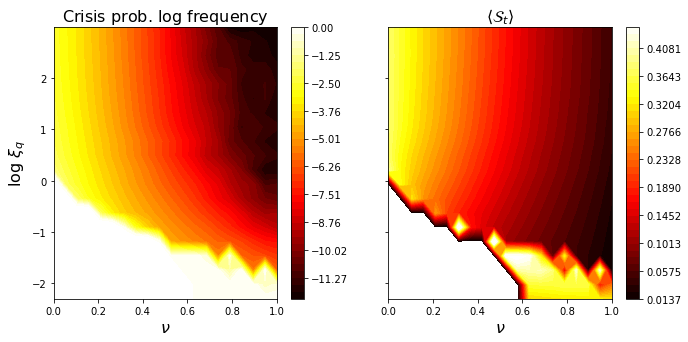

In [5]:
file = open('data_shock_v_ratio.dict', 'rb')
data = pickle.load(file)
file.close()

data['proportion'].fillna('10', inplace=True)
data['sharpe'].fillna('0', inplace=True)

fig, ax = plt.subplots(1,2,sharey = 'row', figsize=(11,5))
col = np.asarray([0.001,.001,.001])

x,y,z = data['proportion'].columns, np.log(data['proportion'].index), np.log(data['proportion'].astype(float))
#CS = ax[0].contourf(x,y,z,levels=[-8,-6,-4,-2,0], colors=['r',[.8,0,0],[.6,0,0],[.4,0,0],'k'])
CS = ax[0].contourf(x,y,z,levels=np.linspace(z.min().min(), 0, level_n), cmap=cmap)
plt.colorbar(CS, ax=ax[0])

x,y,z = data['sharpe'].columns , np.log(data['sharpe'].index), data['sharpe']
#SH = ax[1].contourf(x,y,z, levels=[0,.05,.1,.15,.2,.25,.3,.35,.4])
SH = ax[1].contourf(x,y,z, levels=np.linspace(z.min().min(), z.max().max(), level_n), cmap=cmap)
plt.colorbar(SH, ax=ax[1])

#ax[1].clabel(SH, inline=1, fontsize=10)
#ax[0].clabel(CS, inline=1, fontsize=10)

ax[0].set_title(r'Crisis prob. $\log$ frequency', fontsize = 16)
ax[0].set_ylabel(r'$\log$ $\xi_q$', fontsize = 16)
ax[0].set_xlabel(r'$\nu$', fontsize = 16)

ax[1].set_title(r'$\langle\mathcal{S}_t \rangle$', fontsize = 16)
ax[1].set_xlabel(r'$\nu$', fontsize = 16)

#a = ax[1].twinx()
#a.set_yticks([])
#a.set_ylabel('$\sigma_z = $' + str(params['sigmaZ']) + r', $\theta_s$ = '+ str(params['s_theta']), fontsize = 16)

plt.savefig('fig_phase_port_ratiovssq.eps', format = 'eps')

In [6]:
file = open('data_shock_v_sigmaZ.dict', 'rb')
data = pickle.load(file)
file.close()

data['proportion'].fillna('10', inplace=True)
data['sharpe'].fillna('0', inplace=True)


fig, ax = plt.subplots(1,2,sharey = 'row', figsize=(11,5))

col = np.asarray([0.001,.001,.001])


x,y,z = data['proportion'].columns, np.log(data['proportion'].index), np.log(data['proportion'].astype(float))
#CS = ax[0].contourf(x,y,z,levels=[-8,-6,-4,-2,0], colors=['r',[.8,0,0],[.6,0,0],[.4,0,0],'k'])
CS = ax[0].contourf(x,y,z,levels=np.linspace(z.min().min(), 0, level_n), cmap=cmap)
plt.colorbar(CS, ax=ax[0])

x,y,z = data['sharpe'].columns , np.log(data['sharpe'].index), data['sharpe']
#SH = ax[1].contourf(x,y,z, levels=[0,.05,.1,.15,.2,.25,.3,.35,.4])
SH = ax[1].contourf(x,y,z, levels=np.linspace(0, z.max().max(), level_n), cmap=cmap)
plt.colorbar(SH, ax=ax[1])

#ax[1].clabel(SH, inline=1, fontsize=10)
#ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title(r'Crisis prob. $\log$ frequency', fontsize = 16)
ax[0].set_ylabel(r'$\log$ $\xi_q$', fontsize = 16)
ax[0].set_xlabel(r'$\sigma_z$', fontsize = 16)
#ax[0].set_xticks([0,.5,1,1.5,2])
#ax[0].set_xticklabels(['0','0.5','1','1.5','2'])
#ax[1].set_xticks([0,.5,1,1.5,2])
#ax[1].set_xticklabels(['0','0.5','1','1.5','2'])
ax[1].set_title(r'$\langle\mathcal{S}_t \rangle$', fontsize = 16)
#ax[1].set_ylabel(r'$\log\ q_{shock}$', fontsize = 16)
ax[1].set_xlabel(r'$\sigma_z$', fontsize = 16)
#a = ax[1].twinx()
#a.set_yticks([])
#a.set_ylabel( '$\nu = $' + str(params['ratio']) + r', $\theta_s$ = '+ str(params['s_theta']), fontsize = 16)

plt.savefig('fig_phase_port_szvssq.eps', format = 'eps')

EOFError: Ran out of input

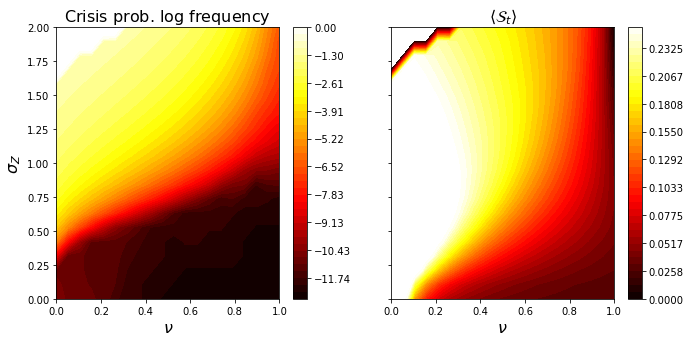

In [7]:
file = open('data_sigmaZ_v_ratio.dict', 'rb')
data = pickle.load(file)
file.close()

data['proportion'].fillna('10', inplace=True)
data['sharpe'].fillna('0', inplace=True)


fig, ax = plt.subplots(1,2,sharey = 'row', figsize=(11,5))

col = np.asarray([0.001,.001,.001])


x,y,z = data['proportion'].columns, data['proportion'].index, np.log(data['proportion'].astype(float))
#CS = ax[0].contourf(x,y,z,levels=[-8,-6,-4,-2,0], colors=['r',[.8,0,0],[.6,0,0],[.4,0,0],'k'])
CS = ax[0].contourf(x,y,z,levels=np.linspace(z.min().min(), 0, level_n), cmap=cmap)
plt.colorbar(CS, ax=ax[0])

x,y,z = data['sharpe'].columns , data['sharpe'].index, data['sharpe']
#SH = ax[1].contourf(x,y,z, levels=[0,.05,.1,.15,.2,.25,.3,.35,.4])
SH = ax[1].contourf(x,y,z, levels=np.linspace(0, z.max().max(), level_n), cmap=cmap)
plt.colorbar(SH, ax=ax[1])

#ax[1].clabel(SH, inline=1, fontsize=10)
#ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title(r'Crisis prob. $\log$ frequency', fontsize = 16)
ax[0].set_ylabel(r'$\sigma_Z$', fontsize = 16)
ax[0].set_xlabel(r'$\nu$', fontsize = 16)
#ax[0].set_xticks([0,.5,1,1.5,2])
#ax[0].set_xticklabels(['0','0.5','1','1.5','2'])
#ax[1].set_xticks([0,.5,1,1.5,2])
#ax[1].set_xticklabels(['0','0.5','1','1.5','2'])
ax[1].set_title(r'$\langle\mathcal{S}_t \rangle$', fontsize = 16)
#ax[1].set_ylabel(r'$\log\ q_{shock}$', fontsize = 16)
ax[1].set_xlabel(r'$\nu$', fontsize = 16)
#a = ax[1].twinx()
#a.set_yticks([])
#a.set_ylabel( '$\nu = $' + str(params['ratio']) + r', $\theta_s$ = '+ str(params['s_theta']), fontsize = 16)

plt.savefig('fig_phase_port_szvsratio.eps', format = 'eps')

In [11]:
data

{'proportion': ratio     0.000000  0.052632  0.105263  0.157895  0.210526  0.263158  \
 sigmaZ                                                                 
 0.000000  0.000025   0.00002  0.000018  0.000016  0.000014  0.000009   
 0.105263  0.000024  0.000018  0.000016  0.000015  0.000014  0.000011   
 0.210526  0.000019  0.000016  0.000016  0.000014  0.000014  0.000012   
 0.315789  0.000227  0.000016  0.000016  0.000014  0.000013  0.000012   
 0.421053  0.003215  0.000321  0.000048  0.000014  0.000014  0.000013   
 0.526316  0.013519  0.003833  0.001128  0.000325    0.0001  0.000036   
 0.631579  0.032349  0.014631  0.006599  0.002972  0.001327  0.000604   
 0.736842  0.058395  0.033639  0.019499  0.011136  0.006217  0.003465   
 0.842105  0.088931  0.059693  0.039914   0.02643  0.017138  0.010883   
 0.947368  0.121895  0.089493  0.065857  0.047942  0.034466  0.024273   
 1.052632  0.156483  0.121945  0.095155  0.073682  0.056752  0.042965   
 1.157895   0.19256  0.157044  0.1279